In [1]:
import random
import matplotlib.pyplot as plt
import seaborn

In [24]:
class dyadic:
    
    '''
    d = None is taken to mean d = -inf (denom = 0 or x = inf)
    '''
    def __init__(self,a:int,d,reduce=True):
        assert((d is None) or (type(d) == int))
        if reduce:
            while (a != 0) and ((a % 2) == 0):
                a //= 2
                d -= 1
        self.a = a
        self.d = d
        
        if d is None:
            self.truedenom = 0
        else:
            self.truedenom = None
            
    def __add__(self,other):
        if self.d > other.d:
            oscale = 1 << (self.d - other.d)
            sscale = 1
        elif other.d > self.d:
            oscale = 1
            sscale = 1 << (other.d - self.d)
        else:
            oscale = sscale = 1
        return dyadic(self.a*sscale + other.a*oscale,max(self.d,other.d),reduce=True)
    
    def __neg__(self):
        return dyadic(-self.a,self.d,reduce=False)
    
    def __sub__(self,other):
        return self + (-other)
    
    def __eq__(self,other):
        return (self.a == other.a) and (self.d == other.d)
    
    def __abs__(self):
        return dyadic(abs(self.a),self.d,reduce=False)
    
    def __lt__(self,other):
        if self.d == other.d:
            return self.a < other.a
        if self.d < other.d:
            return self.a*(other.d-self.d) < other.a
        return self.a < other.a*(self.d-other.d)
    
    def __le__(self,other):
        return (self < other) or (self == other)
    
    def __ge__(self,other):
        return not (self < other)
    
    def __gt__(self,other):
        return (self > other) and (self != other)
    
    def child(self,i):
        if i <= 0:
            raise AttributeError("Child zero (or negative) does not exist")
        ch = dyadic((1<<i)*self.a - 1,self.d+i,reduce=False)
        #2^ia - 1 is odd, so reduction isn't necessary
        return ch
    
    
    def parent(self):
        if self.d == 0:
            return None
        k = 0
        i = self.a+1
        while (i & 1) == 0:
            i >>= 1
            k += 1
        return dyadic(i,self.d-k,reduce=False)
    
    def is_ancestor_of(self,other):
        if other.d < self.d:
            return False
        if other.d == self.d:
            return other.a == self.a
        
        s = self.sprev()
        scale_s = 1 << (other.d - s.d)
        scale_a = 1 << (other.d - self.d)
        
        return ((scale_s*s.a) < other.a) and (other.a <= (self.a*scale_a))
    
    def sprev(self):
        if self.a == 1:
            return dyadic(0,0)
        par = self.parent()
        i = self.d - par.d
        if i == 1:
            return par.sprev()
        return par.child(i-1)
    
    '''
    distance to root
    note this is UPPER BOUNDED by self.d
    '''
    def dtr(self) -> int:
        if self.a == 1:
            return self.d
        p = self.parent()
        return p.dtr() + 1
    
    def __repr__(self):
        if self.truedenom is None:
            self.truedenom = 1<<self.d
        if self.truedenom == 0:
            return ("-" if self.a < 0 else "") + "INF"
        return "{}/{}".format(self.a,self.truedenom)
    
    
    def __hash__(self):
        return (self.a,self.d).__hash__()

    
'''
local routing preference function
'''
def pref(x:dyadic,y:dyadic,reference:dyadic) -> dyadic:
    #first do the x=y case
    if x == y:
        return x
    if x == reference:
        return x#literally just the target
    if y == reference:
        return y
    xat = x.is_ancestor_of(reference)
    tax = reference.is_ancestor_of(x)
    yat = y.is_ancestor_of(reference)
    tay = reference.is_ancestor_of(y)
    xay = x.is_ancestor_of(y)
    yax = y.is_ancestor_of(x)
    #now do the x-unrelated, y-related ancestry case
    if ((not xat) and (not tax)) and (tay or yat):
        return y
    #x-related, y-unrelated
    if ((not yat) and (not tay)) and (tax or xat):
        return x
    #neither related
    if (not xat) and (not tax) and (not yat) and (not tay):
        #we don't know what the ancestry is like, so pick the one that's HIGHER in the tree
        #begs the question: are we actually getting anything from using dyadics?
        return x if (x.d < y.d) else y
    #both related
    xdtr = x.dtr()
    ydtr = y.dtr()
    tdtr = reference.dtr()
    return x if abs(xdtr - tdtr) < abs(ydtr - tdtr) else y

def ldt_inner(x,max_depth,max_degr,randomize_degr,depth=0):
    s = ''
    if depth > max_depth:
        return s
    
    s += '\t'*depth
    s += '[.' + str(x)
    s += '\n'
    
    degr = random.randint(0,max_degr)
    #print all children
    for chi in range(1,degr+1):
        ch = x.child(chi)
        s += ldt_inner(ch,max_depth,max_degr,randomize_degr,depth=depth+1)
    
    s += '\t'*depth
    s += ']\n'
    return s
    
def latex_dyadic_tree(depth,max_degr,randomize_degr=True):
    s = '\\Tree'
    x = dyadic(1,0)
    s += ldt_inner(x,depth,max_degr,randomize_degr)
    print(s)

Gonna test the preference function as a router

In [17]:
def gen_ER_dyadic_embed(n,p):
    #we'll use a dict for the adj list
    G = {x:set() for x in range(n)}
    addr_map = {0:dyadic(1,0)}#use this for seen also
    #use bfs to make sure we get an actual tree out of this
    q = [0]
    while len(q) > 0:
        current = q.pop(0)
        neighbors = {n for n in G if (random.choices([True,False],weights=[p,1-p])[0]) and (n != current)}
        G[current] = G[current].union(neighbors)
        
        di = 1
        for n in neighbors:
            #undirected also
            G[n].add(current)
            if n not in addr_map:
                #give n my next address
                addr_map.update({n:addr_map[current].child(di)})
                di += 1
                q.append(n)
    
    #convert to having the dyadics be the nodes themselves
    G = {addr_map[x]:[addr_map[y] for y in G[x]] for x in G if x in addr_map}#drop unvisited nodes also
    return G

'''
since apparently everything python does is stupid and wrong we'll just do this ourselves

repechage algorithm: pair off the remaining ns and compare, drop the loser, repeat until 1
remains
'''
def nearest_neigh_to_ref(ns,ref):
    if len(ns) == 1:
        return list(ns)[0]
    rem_ns = []
    for i in range(len(ns)-1):
        #compate i and i+1
        winner = pref(ns[i],ns[i+1],ref)
        rem_ns.append(winner)
    return nearest_neigh_to_ref(rem_ns,ref)
    

def groute_st(G,s,t):
    from functools import cmp_to_key
    assert(s != t)
    assert(s in G)
    assert(t in G)
    
    f = pysort_pref(t)
    current = s
    path = [s]
    while current != t:
#         if len(path) > 5:
#             return path
#         print(current,G[current])
        current = nearest_neigh_to_ref(G[current],t)
#         print(current)
        path.append(current)
    return path

In [5]:
random.seed(1)
G = gen_ER_dyadic_embed(100,0.05)
G

{1/1: [1/2,
  3/4,
  7/8,
  15/16,
  31/32,
  8183/8192,
  63/64,
  127/128,
  255/256,
  511/512,
  1023/1024],
 501/512: [507/1024,
  1981/4096,
  3/4,
  253/256,
  1979/4096,
  27/32,
  251/256,
  1019/2048,
  2015/4096,
  16367/16384,
  41/64,
  505/512,
  2015/2048],
 125/128: [29/64,
  1981/4096,
  57/64,
  63/64,
  249/256,
  117/256,
  25/32,
  59/64,
  989/1024,
  8183/8192,
  7/32,
  47/64],
 5/8: [3/4,
  19/32,
  31/32,
  1019/2048,
  503/512,
  511/512,
  9/16,
  237/256,
  31/64,
  95/128],
 239/256: [119/128,
  61/64,
  989/1024,
  3/4,
  15/16,
  5/16,
  123/256,
  57/64,
  477/512,
  503/512,
  249/256,
  955/1024],
 53/64: [115/128, 27/32, 509/512, 123/128, 2015/4096, 1979/4096, 123/256],
 251/512: [115/128, 25/32, 63/128, 1/2, 255/512, 991/2048, 495/512, 237/256],
 1981/4096: [115/128,
  501/512,
  107/128,
  125/128,
  2029/2048,
  955/1024,
  991/2048,
  505/512],
 253/512: [2045/2048,
  507/512,
  237/256,
  107/128,
  55/64,
  7/32,
  127/256,
  255/512,
  955/102

In [13]:
dyadic(501,9).is_ancestor_of(dyadic(989,10))

False

In [14]:
dyadic(989,10).is_ancestor_of(dyadic(501,9))

False

In [16]:
groute_st(G,dyadic(501,9),dyadic(989,10))

501/512 [507/1024, 1981/4096, 3/4, 253/256, 1979/4096, 27/32, 251/256, 1019/2048, 2015/4096, 16367/16384, 41/64, 505/512, 2015/2048]
3/4
3/4 [1/1, 501/512, 5/8, 239/256, 23/32, 15/32, 55/64, 247/256, 9/16, 11/16, 47/64, 95/128]
1/1
1/1 [1/2, 3/4, 7/8, 15/16, 31/32, 8183/8192, 63/64, 127/128, 255/256, 511/512, 1023/1024]
31/32
31/32 [1/1, 5/8, 2045/2048, 61/64, 3/16, 495/512, 123/128, 247/256]
495/512
495/512 [251/512, 31/32, 127/128, 11/32, 505/512, 1015/1024, 4031/8192, 221/256, 989/1024, 5/16, 8183/8192, 255/256]
989/1024


[501/512, 3/4, 1/1, 31/32, 495/512, 989/1024]

In [19]:
ls = 0
for xn in G:
    for yn in G:
        if xn != yn:
            ls += len(groute_st(G,xn,yn))
            
print('Avg path length: {:3f}'.format(ls/(len(G)*(len(G)-1))))

Avg path length: 4.363030


Seems to be working now *sigh*

In [158]:
t = dyadic(9,4)
nearest_neigh_to_ref(G[dyadic(1,0)] + [dyadic(1,0)],t)

5/8

# Fine. I'll do it myself

In [156]:
t = dyadic(9,4)
l = min(G[dyadic(1,0)] + [dyadic(1,0)],key=lambda x: dyadic_sorter(x,t))
print(l)

5/32


In [147]:
f = pysort_pref(dyadic(9,4))
l = list(sorted(G[dyadic(1,0)] + [dyadic(1,0)],key=cmp_to_key(f)))
for i in range(len(l)-1):
    fv = f(l[i],l[i+1])
    if fv >= 0:
        print('incorrectly sorted {} and {} (fn valued to {})'.format(l[i],l[i+1],fv))

incorrectly sorted 5/32 and 5/8 (fn valued to 1)
incorrectly sorted 15/16 and 3/16 (fn valued to 1)
incorrectly sorted 1/4 and 7/8 (fn valued to 1)


## \-_\- python cmp_to_key is broken

## ...or sorted is broken?????

# EVERYTHING IS BROKEN

In [135]:
pref(dyadic(5,5),dyadic(55,6),dyadic(9,4))

5/32

In [133]:
dyadic(5,3).is_ancestor_of(dyadic(9,4))

True

In [131]:
groute_st(G,dyadic(1,0),dyadic(9,4))

1/1 [5/32, 5/8, 3/4, 1/1, 1/2, 5/16, 15/16, 3/16, 1/4, 7/8, 55/64]
5/32 [5/32, 1/1, 5/16, 3/16, 25/32]
5/32 [5/32, 1/1, 5/16, 3/16, 25/32]
5/32 [5/32, 1/1, 5/16, 3/16, 25/32]
5/32 [5/32, 1/1, 5/16, 3/16, 25/32]
5/32 [5/32, 1/1, 5/16, 3/16, 25/32]
5/32 [5/32, 1/1, 5/16, 3/16, 25/32]
5/32 [5/32, 1/1, 5/16, 3/16, 25/32]
5/32 [5/32, 1/1, 5/16, 3/16, 25/32]
5/32 [5/32, 1/1, 5/16, 3/16, 25/32]


[1/1, 5/32, 5/32, 5/32, 5/32, 5/32, 5/32, 5/32, 5/32, 5/32, 5/32]

In [129]:
ls = 0
for xn in G:
    for yn in G:
        if xn != yn:
            print(xn,yn)
            ls += len(groute_st(G,xn,yn))
            
print('Avg path length: {:3f}'.format(ls/(len(G)*(len(G)-1))))

1/1 25/32
1/1 11/16
1/1 1/8
1/1 5/16
1/1 11/32
1/1 1/4
1/1 5/32
1/1 1/2
1/1 3/4
1/1 9/16


KeyboardInterrupt: 

In [91]:
G[dyadic(47,7)]

[1/8, 5/16, 45/64, 23/32, 1/16]

In [77]:
[pref(dyadic(111,7),x,dyadic(27,5)) for x in G[dyadic(111,7)]]

3/4 3/128 3/32
9/16 3/128 9/32
1/4 3/128 19/32
221/256 3/128 5/256
59/64 3/128 5/64
15/16 3/128 3/32


[111/128, 111/128, 111/128, 111/128, 111/128, 111/128]

In [41]:
1 << 12

4096

In [4]:
f = pysort_pref(dyadic(3,3))

In [12]:
adj = [dyadic(x,y) for x,y in [[1,0],[3,2],[15,4],[9,5],[21,5]]]
adj.append(dyadic(13,6))#starting from here
adj

[1/1, 3/4, 15/16, 9/32, 21/32, 13/64]

[1/1, 9/32, 3/4, 15/16, 21/32]

In [109]:
pref(dyadic(1,0),dyadic(5,4).child(1).child(1),dyadic(3,3))

1/1

In [92]:
pref(dyadic(3,3),dyadic(13,6),dyadic(1,0))

3/8

In [23]:
dyadic(1311541854715,111).dtr()

88

In [11]:
%%timeit
n = random.randint(1,1000)
a = (random.randint(1,2**(n-1))*2)+1#make sure this is odd
dtr(dyadic(a,n))

305 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%%timeit
n = random.randint(1,128)
a = (random.randint(1,2**(n-1))*2)+1#make sure this is odd
dtr(dyadic(a,n))

39.1 µs ± 913 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### Honestly this is fast enough... esp keeping in mind this is python

1000 max n is something like $2^{1000} \approx 10^{301}$ nodes.

In [23]:
dim = 1000
m = [[(dtr(dyadic(a,n)) if (a <= 2**n) else -1) for a in range(1,2*dim+2,2)] for n in range(dim+1)]

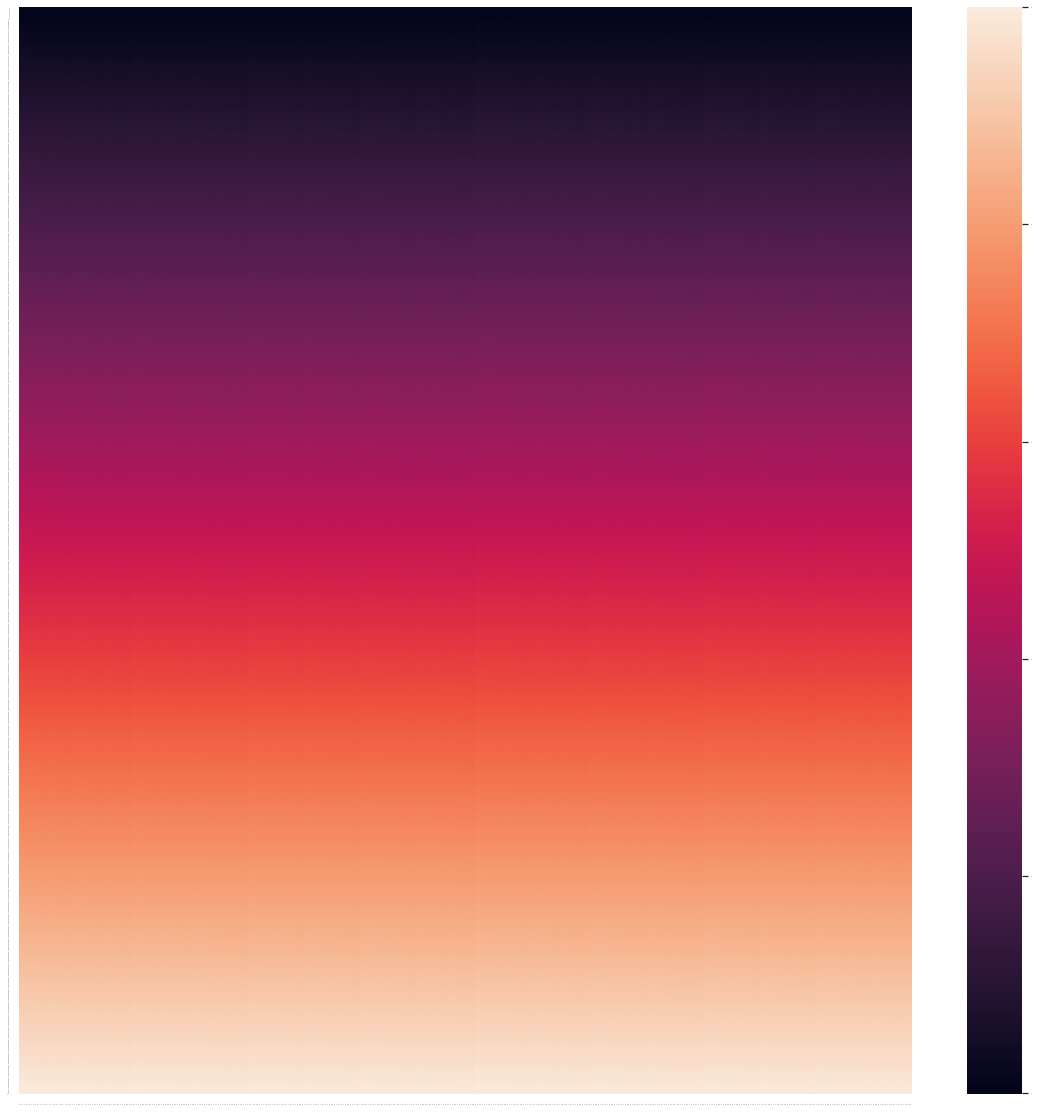

In [24]:
plt.figure(figsize=(20,20))
seaborn.heatmap(m)
seaborn.set(font_scale=0.01)

Aight there's something really quite regular here... just need to figure it out.